In [12]:
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from torch.utils.data import random_split
from sklearn.model_selection import KFold
from torch.utils.data import random_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import torch.nn.functional as F
#from torchsummary import summary
import tensorflow as tf
import torch.nn as nn
import torch.optim as optim
import os
import cv2
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


In [13]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((28, 28)),                 
    transforms.ToTensor(),              
])

In [14]:
dataset = ImageFolder(root='/Users/mogankumarnarsozhan/Documents/VSCODE/cnn_dataset', transform=transform)

Splitting the dataset into training, validation and testing

In [15]:
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

In [16]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f'Training samples: {len(train_dataset)}')
print(f'validation samples: {len(val_dataset)}')
print(f'Testing samples: {len(test_dataset)}')

Training samples: 80640
validation samples: 10080
Testing samples: 10080


Defining the hyper parameters

In [17]:
batch_size = 32
learning_rate = 0.001
momentum = 0.9
weight_decay = 5e-4
num_classes = 36

The base VGG-13 Version B model

In [18]:
class VGG13B(nn.Module):
    def __init__(self, num_classes=36):
        super(VGG13B, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.block5 = nn.Sequential(
            # nn.Conv2d(512, 512, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.Conv2d(512, 512, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

Model optimization and loss function

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG13B(num_classes=36).to(device)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Training and validation of the datasets

In [21]:
from tqdm import tqdm

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

num_epochs = 3
for epoch in range(num_epochs):
    #TRAINING LOOP
    start_time = time.time()
    model.train()
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_running_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    
    train_accuracy = 100 * train_correct / train_total
    train_loss = train_running_loss / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    
    #VALIDAATION LOOP
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validating Epoch {epoch+1}/{num_epochs}", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_accuracy = 100 * val_correct / val_total
    val_loss = val_running_loss / len(val_loader)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)

    end_time = time.time()
    epoch_duration = end_time - start_time


    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    scheduler.step()


Training Epoch 1/3:   0%|          | 0/1260 [00:00<?, ?it/s]

Epoch [1/3]
Train Loss: 0.5850, Train Accuracy: 81.43%
Validation Loss: 0.3466, Validation Accuracy: 87.30%


Epoch [2/3]
Train Loss: 0.3494, Train Accuracy: 87.81%
Validation Loss: 0.3614, Validation Accuracy: 88.28%


Epoch [3/3]
Train Loss: 0.3151, Train Accuracy: 88.90%
Validation Loss: 0.3653, Validation Accuracy: 88.22%


Plottting my training and validaition accuracy and loss

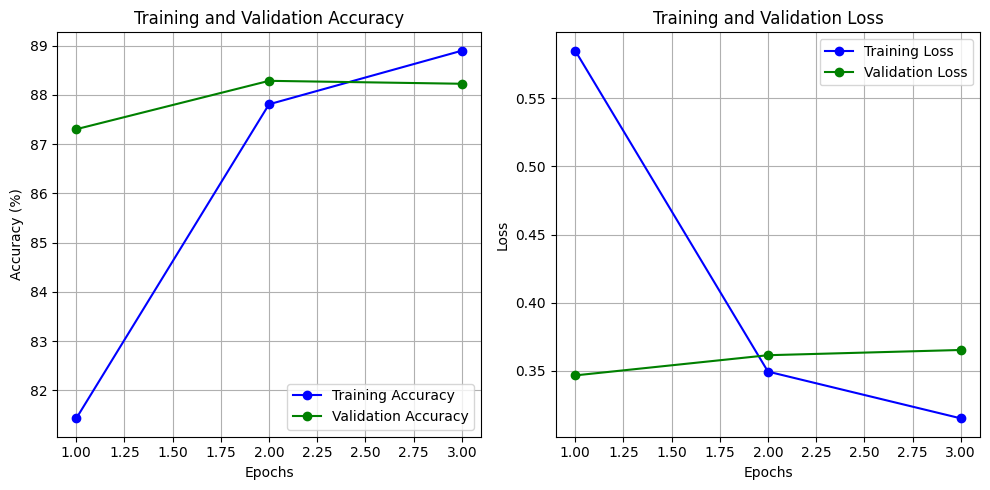

In [28]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(loc='lower right')
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='green', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

In [29]:
print("Train Accuracies:", train_accuracies)
print("Validation Accuracies:", val_accuracies)


Train Accuracies: [81.43105158730158, 87.80753968253968, 88.89508928571429]
Validation Accuracies: [87.3015873015873, 88.28373015873017, 88.22420634920636]


Testing the data

In [30]:
model.eval()

test_accuracies = []
test_losses = []  
test_running_loss = 0.0
test_correct = 0
all_labels = []
all_probs = [] 
all_predictions = []
best_val_loss = float('inf')
best_model_path = '/Users/mogankumarnarsozhan/Documents/VSCODE/mogankum_assignment2_part_4.pt'
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100 * test_correct / test_total
test_loss = test_running_loss / len(test_loader)
test_accuracies.append(test_accuracy)
test_losses.append(test_loss)

if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch {epoch+1}: Best validation loss updated ({best_val_loss:.4f})")


print(f"Test Accuracy: {test_accuracy:.2f}%")
conf_matrix = confusion_matrix(all_labels, all_predictions)


Epoch 3: Best validation loss updated (0.3653)
Test Accuracy: 88.20%


Plotting the accuracy and loss for the testing data

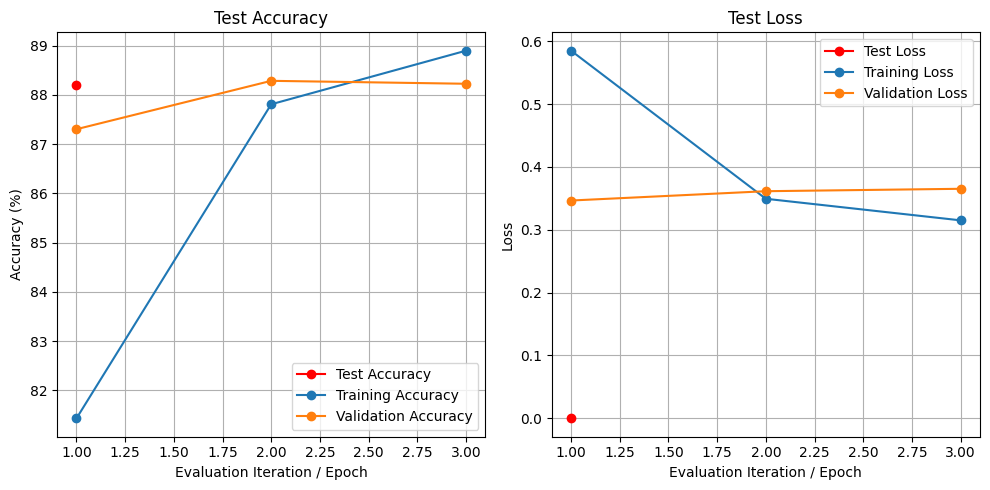

In [31]:
plt.figure(figsize=(10, 5))

#AACCURACY PLOT
plt.subplot(1, 2, 1)
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy', color='red', marker='o')
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Test Accuracy')
plt.xlabel('Evaluation Iteration / Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(loc='lower right')
plt.grid(True)

#LOSS PLOT
plt.subplot(1, 2, 2)
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', color='red', marker='o')
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.title('Test Loss')
plt.xlabel('Evaluation Iteration / Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

Confusion matrix

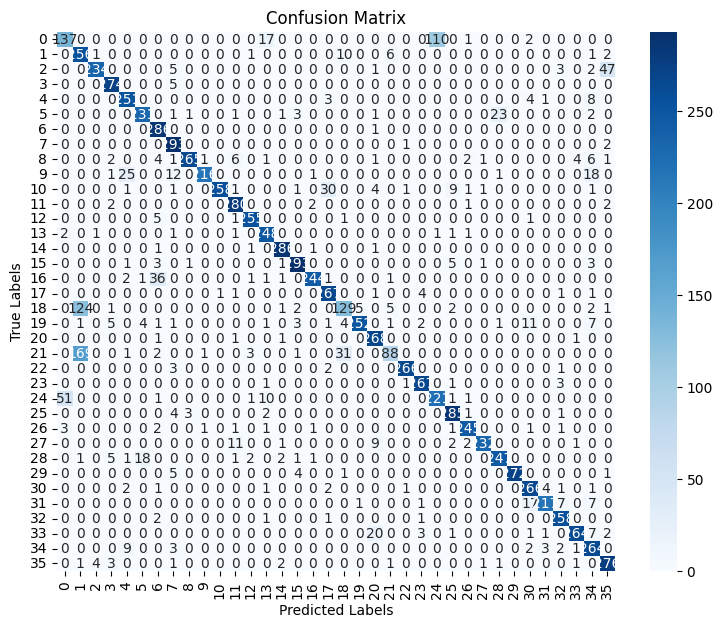

In [32]:
plt.figure(figsize=(9,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

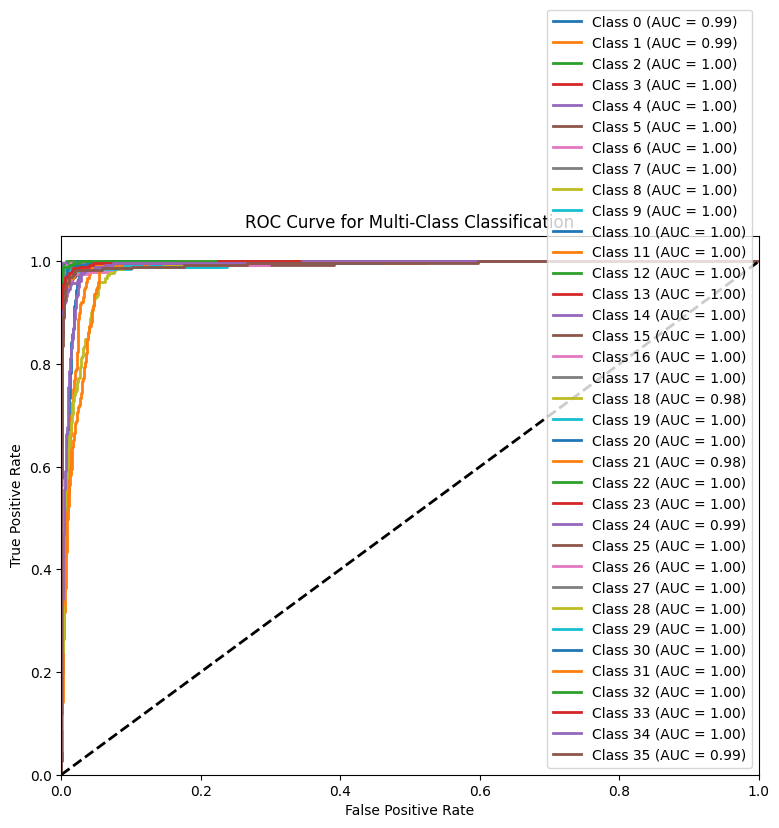

In [27]:
all_preds = np.array(all_predictions)
all_labels = np.array(all_labels)
all_probs = np.vstack(all_probs)

num_classes = 36
binarized_labels = label_binarize(all_labels, classes=np.arange(num_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(9, 7))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {0} (AUC = {1:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()

REFERENCES:

https://pytorch.org/vision/0.12/generated/torchvision.models.vgg13.html

https://pytorch.org/vision/main/models/generated/torchvision.models.vgg13.html

https://arxiv.org/abs/1409.1556

Assignment 2 - Checkpoint part 1 and 2 